# Global Prediction Reasoning Analysis

This notebook provides detailed reasoning for ML predictions stored in `eda_smartlist.us_wealth_management_smartlist.ML_predictions_single_policy`.

- Buckets : <=70,<=60

In [0]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================
import os
import pickle
from typing import Dict, Any, List, Tuple

import mlflow
import numpy as np
import pandas as pd
import shap
from mlflow.tracking import MlflowClient
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# Configuration
PREDICTIONS_TABLE = "eda_smartlist.us_wealth_management_smartlist.ML_predictions_single_policy"
SOURCE_TABLE = "dl_tenants_daas.us_wealth_management.wealth_management_client_metrics"
MODEL_NAME = "eda_smartlist.models.lgbm_model_hyperparameter_last2products"
MODEL_VERSION = "1"
ARTIFACTS_LOCAL_PATH = "/Workspace/EDA_workspace/RA Smart List/Smart List (NEW)/multiproduct_smartlist/Final_model_files/artifacts.pkl"

# Initialize Spark
spark = SparkSession.builder.getOrCreate()

print("=" * 80)
print("PREDICTION REASONING ANALYSIS")
print("=" * 80)


PREDICTION REASONING ANALYSIS


In [0]:
# ============================================================================
# PREPROCESSING HELPER FUNCTIONS (from training notebook)
# ============================================================================

def create_product_category_column(df):
    """Create product_category column from prod_lob, sub_product_level_1, and sub_product_level_2."""
    return df.withColumn(
        "product_category",
        F.when(F.col("prod_lob") == "LIFE", "LIFE_INSURANCE")
        .when(
            F.col("sub_product_level_1").isin(
                "VLI", "WL", "UL/IUL", "TERM", "PROTECTIVE PRODUCT"
            ),
            "LIFE_INSURANCE",
        )
        .when(F.col("sub_product_level_2").like("%LIFE%"), "LIFE_INSURANCE")
        .when(
            F.col("sub_product_level_2").isin(
                "VARIABLE UNIVERSAL LIFE",
                "WHOLE LIFE",
                "UNIVERSAL LIFE",
                "INDEX UNIVERSAL LIFE",
                "TERM PRODUCT",
                "VARIABLE LIFE",
                "SURVIVORSHIP WHOLE LIFE",
                "MONY PROTECTIVE PRODUCT",
            ),
            "LIFE_INSURANCE",
        )
        .when(
            F.col("prod_lob").isin("GROUP RETIREMENT", "INDIVIDUAL RETIREMENT"),
            "RETIREMENT",
        )
        .when(
            F.col("sub_product_level_1").isin(
                "EQUIVEST",
                "RETIREMENT 401K",
                "ACCUMULATOR",
                "RETIREMENT CORNERSTONE",
                "SCS",
                "INVESTMENT EDGE",
            ),
            "RETIREMENT",
        )
        .when(
            (F.col("sub_product_level_2").like("%403B%"))
            | (F.col("sub_product_level_2").like("%401%"))
            | (F.col("sub_product_level_2").like("%IRA%"))
            | (F.col("sub_product_level_2").like("%SEP%")),
            "RETIREMENT",
        )
        .when(F.col("prod_lob") == "BROKER DEALER", "INVESTMENT")
        .when(
            F.col("sub_product_level_1").isin(
                "INVESTMENT PRODUCT - DIRECT",
                "INVESTMENT PRODUCT - BROKERAGE",
                "INVESTMENT PRODUCT - ADVISORY",
                "DIRECT",
                "BROKERAGE",
                "ADVISORY",
                "CASH SOLICITOR",
            ),
            "INVESTMENT",
        )
        .when(
            (F.col("sub_product_level_2").like("%Investment%"))
            | (F.col("sub_product_level_2").like("%Brokerage%"))
            | (F.col("sub_product_level_2").like("%Advisory%")),
            "INVESTMENT",
        )
        .when(F.col("prod_lob") == "NETWORK", "NETWORK_PRODUCTS")
        .when(
            (F.col("sub_product_level_1") == "NETWORK PRODUCTS")
            | (F.col("sub_product_level_2") == "NETWORK PRODUCTS"),
            "NETWORK_PRODUCTS",
        )
        .when(
            (F.col("prod_lob") == "OTHERS") & (F.col("sub_product_level_1") == "HAS"),
            "DISABILITY",
        )
        .when(F.col("sub_product_level_2") == "HAS - DISABILITY", "DISABILITY")
        .when(F.col("prod_lob") == "OTHERS", "HEALTH")
        .when(F.col("sub_product_level_2") == "GROUP HEALTH PRODUCTS", "HEALTH")
        .otherwise("OTHER"),
    )


def add_asset_allocation_ratios(df):
    """Add asset allocation ratio features based on wealth metrics."""
    df = df.withColumn(
        "stock_allocation_ratio",
        F.col("wc_assetmix_stocks")
        / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(
            F.lit(None)
        ),
    )
    df = df.withColumn(
        "bond_allocation_ratio",
        F.col("wc_assetmix_bonds")
        / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(
            F.lit(None)
        ),
    )
    df = df.withColumn(
        "annuity_allocation_ratio",
        F.col("wc_assetmix_annuity")
        / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(
            F.lit(None)
        ),
    )
    df = df.withColumn(
        "mutual_fund_allocation_ratio",
        F.col("wc_assetmix_mutual_funds")
        / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(
            F.lit(None)
        ),
    )
    return df


def impute_missing_values(df, categorical_cols, categorical_mode="UNKNOWN"):
    """Impute missing values in DataFrame."""
    numeric_cols = [
        "first_acct_val_amt",
        "first_face_amt",
        "first_cash_val_amt",
        "wc_total_assets",
        "wc_assetmix_stocks",
        "wc_assetmix_bonds",
        "wc_assetmix_mutual_funds",
        "wc_assetmix_annuity",
        "wc_assetmix_deposits",
        "wc_assetmix_other_assets",
        "psn_age",
        "stock_allocation_ratio",
        "bond_allocation_ratio",
        "annuity_allocation_ratio",
        "mutual_fund_allocation_ratio",
        "age_at_first_policy",
        "years_to_second_policy",
    ]

    # Median imputation for numeric columns
    fill_numeric = {}
    for c in numeric_cols:
        if c in df.columns:
            try:
                median_val = df.approxQuantile(c, [0.5], 0.001)[0]
            except Exception:
                median_val = 0.0
            if median_val is None:
                median_val = 0.0
            fill_numeric[c] = float(median_val)

    result_df = df.fillna(fill_numeric)

    # Mode imputation for categoricals
    for c in categorical_cols:
        if c in result_df.columns:
            try:
                mode_row = (
                    result_df.groupBy(c)
                    .count()
                    .orderBy(F.desc("count"))
                    .first()
                )
                mode_val = (
                    mode_row[0]
                    if mode_row and mode_row[0] is not None
                    else categorical_mode
                )
            except Exception:
                mode_val = categorical_mode

            result_df = result_df.withColumn(
                c,
                F.when(F.col(c).isNull(), F.lit(mode_val)).otherwise(F.col(c)),
            )

    return result_df


def encode_categorical_features(df, categorical_cols, spark_context, categorical_mappings=None):
    """Encode categorical features to integer indices."""
    if categorical_mappings is None:
        categorical_mappings = {}

    result_df = df

    for c in categorical_cols:
        if c in categorical_mappings:
            mapping = categorical_mappings[c]
            b = spark_context.broadcast(mapping)
            result_df = result_df.withColumn(
                c + "_idx",
                F.udf(lambda s: int(b.value.get(str(s), 0)), IntegerType())(
                    F.coalesce(F.col(c).cast("string"), F.lit("UNKNOWN"))
                ),
            )
        else:
            vals = [r[0] for r in result_df.select(c).distinct().collect()]
            mapping = {v: i for i, v in enumerate(sorted([str(x) for x in vals]))}
            categorical_mappings[c] = mapping

            b = spark_context.broadcast(mapping)
            result_df = result_df.withColumn(
                c + "_idx",
                F.udf(lambda s: int(b.value.get(str(s), 0)), IntegerType())(
                    F.coalesce(F.col(c).cast("string"), F.lit("UNKNOWN"))
                ),
            )

    return result_df, categorical_mappings


def get_feature_columns():
    """Get the list of feature columns in the correct order."""
    return [
        "first_acct_val_amt",
        "first_face_amt",
        "first_cash_val_amt",
        "wc_total_assets",
        "wc_assetmix_stocks",
        "wc_assetmix_bonds",
        "wc_assetmix_mutual_funds",
        "wc_assetmix_annuity",
        "wc_assetmix_deposits",
        "wc_assetmix_other_assets",
        "psn_age",
        "stock_allocation_ratio",
        "bond_allocation_ratio",
        "annuity_allocation_ratio",
        "mutual_fund_allocation_ratio",
        "age_at_first_policy",
        "years_to_second_policy",
        "first_product_category_idx",
        "client_seg_idx",
        "client_seg_1_idx",
        "aum_band_idx",
        "channel_idx",
        "agent_segment_idx",
        "branchoffice_code_idx",
        "season_of_first_policy_idx",
    ]


print("✓ Preprocessing functions loaded")


✓ Preprocessing functions loaded


In [0]:
# ============================================================================
# MODEL AND ARTIFACTS LOADING
# ============================================================================

def load_model_and_artifacts() -> Dict[str, Any]:
    """Load the LightGBM model and its preprocessing artifacts."""
    client = MlflowClient()

    # Load registered LightGBM model
    model_uri = f"models:/{MODEL_NAME}/{MODEL_VERSION}"
    print(f"Loading model from {model_uri}...")
    lgbm_model = mlflow.lightgbm.load_model(model_uri)
    print("✓ Model loaded successfully")

    # Try to load artifacts from local path first
    artifacts = None
    if ARTIFACTS_LOCAL_PATH and os.path.exists(ARTIFACTS_LOCAL_PATH):
        print(f"Loading artifacts from local path: {ARTIFACTS_LOCAL_PATH}")
        with open(ARTIFACTS_LOCAL_PATH, "rb") as f:
            artifacts = pickle.load(f)
        print("✓ Artifacts loaded from local path")
    else:
        # Try MLflow run artifacts
        try:
            mv = client.get_model_version(name=MODEL_NAME, version=MODEL_VERSION)
            run_id = mv.run_id
            print(f"Attempting to download artifacts from run {run_id}...")
            artifacts_dir = mlflow.artifacts.download_artifacts(
                artifact_uri=f"runs:/{run_id}/artifacts"
            )
            artifacts_path = os.path.join(artifacts_dir, "artifacts.pkl")
            if os.path.exists(artifacts_path):
                with open(artifacts_path, "rb") as f:
                    artifacts = pickle.load(f)
                print("✓ Artifacts loaded from MLflow")
        except Exception as e:
            print(f"⚠ Could not load artifacts from MLflow: {e}")

    if artifacts is None:
        raise FileNotFoundError(
            f"Could not find artifacts.pkl. Please ensure it exists at {ARTIFACTS_LOCAL_PATH} "
            "or is available in MLflow."
        )

    prod2id = artifacts.get("prod2id")
    id2prod = artifacts.get("id2prod")
    label_map = artifacts.get("label_map")
    num_classes = artifacts.get("num_classes")
    categorical_mappings = artifacts.get("categorical_mappings")
    feature_cols = artifacts.get("feature_cols") or get_feature_columns()

    if prod2id is None or id2prod is None:
        raise ValueError("prod2id/id2prod mappings missing in artifacts.pkl")
    if label_map is None:
        raise ValueError("label_map missing in artifacts.pkl")

    print("✓ All artifacts loaded successfully")
    return {
        "model": lgbm_model,
        "prod2id": prod2id,
        "id2prod": id2prod,
        "label_map": label_map,
        "num_classes": num_classes,
        "categorical_mappings": categorical_mappings,
        "feature_cols": feature_cols,
    }


# Load model and artifacts
ctx = load_model_and_artifacts()
model = ctx["model"]
id2prod = ctx["id2prod"]
label_map = ctx["label_map"]
categorical_mappings = ctx["categorical_mappings"]
feature_cols = ctx["feature_cols"]

# Create inverse label map for predictions
inv_label_map = {v: k for k, v in label_map.items()}
final_id2prod = {
    model_id: id2prod[orig_id]
    for model_id, orig_id in inv_label_map.items()
    if orig_id in id2prod
}

print(f"✓ Model context loaded: {len(feature_cols)} features, {len(final_id2prod)} product classes")


Loading model from models:/eda_smartlist.models.lgbm_model_hyperparameter_last2products/1...


✓ Model loaded successfully
Loading artifacts from local path: /Workspace/EDA_workspace/RA Smart List/Smart List (NEW)/multiproduct_smartlist/Final_model_files/artifacts.pkl
✓ Artifacts loaded from local path
✓ All artifacts loaded successfully
✓ Model context loaded: 25 features, 7 product classes



GLOBAL SHAP COMPARISON: MULTIPLE CONFIDENCE BUCKETS

Loading predictions from table...
✓ Loaded 441,024 total predictions

Dividing clients into confidence buckets...
✓ High confidence (pred_prob >= 0.90): 61,246 clients
✓ Medium-low confidence (pred_prob <= 0.80): 274,159 clients
✓ Low confidence (pred_prob <= 0.70): 185,642 clients
✓ Very low confidence (pred_prob <= 0.60): 114,642 clients
⚠ Sampling 40,000 from high confidence bucket...
⚠ Sampling 40,000 from medium-low confidence bucket...
⚠ Sampling 40,000 from low confidence bucket...
⚠ Sampling 40,000 from very low confidence bucket...

✓ Working with:
  - 40,175 high confidence predictions
  - 40,145 medium-low confidence predictions
  - 40,207 low confidence predictions
  - 39,922 very low confidence predictions

RECONSTRUCTING FEATURES FOR HIGH CONFIDENCE (>=0.90) BUCKET
✓ Found 27,353 unique cont_ids
✓ Filtered to 24,878 single-policy client records
✓ Reconstructed features for 24,878 clients

RECONSTRUCTING FEATURES FOR ME

feature,high_conf_shap,med_low_conf_shap,low_conf_shap,very_low_conf_shap,high_conf_value,med_low_conf_value,low_conf_value,very_low_conf_value
years_to_second_policy,1.213201801323556,1.1641783902758567,1.3506064946362033,1.382466472103982,38.91911139627114,35.766763118688004,35.65811348554887,35.387895041301945
first_product_category_idx,0.33887929375275583,0.3558579169685562,0.35119429140103126,0.3458266555322004,2.567900221547551,1.817995229378155,1.6509575353871773,1.5253536575076638
branchoffice_code_idx,0.29631233001806057,0.09773548711266855,0.22709918419691325,0.2250955186769283,33.67476272530839,30.278693071503856,28.940105467665834,28.30514385353095
age_at_first_policy,0.29402447638219054,0.49031638186688936,0.6741011098412497,0.7060147167747273,28.561068905292704,30.69182430628147,30.658767021094103,30.6441598807995
psn_age,0.22786879108555375,0.2828083677536742,0.32920873633451564,0.34971059054826237,64.63936982030032,63.461862761413435,63.45539827921177,62.94664904238265
annuity_allocation_ratio,0.1940922915471897,0.15660940496694994,0.136800808388559,0.13928578343653383,0.046715474092935624,0.03001373143398492,0.0278724651429555,0.026286688683314685
first_face_amt,0.11438791110446578,0.15441351984863325,0.18672545877097055,0.19394938018924995,27816.9375,111984.8515625,134262.40625,149221.421875
wc_assetmix_annuity,0.10624243570245419,0.10579771671176588,0.10149975877323104,0.10849364667173765,53129.45754054867,27879.562469074168,25151.001417985015,23230.143555136823
agent_segment_idx,0.0844383876104026,0.08758445788256145,0.10117952720849695,0.1083820678606765,0.08812669237712316,0.06873023797636878,0.061421038023869,0.06372866102314594
first_cash_val_amt,0.071828578248373,0.08733907822999452,0.09778700110691164,0.1020218586374503,9969.6171875,17115.1953125,19134.2421875,20056.978515625



CREATING COMPARISON VISUALIZATIONS


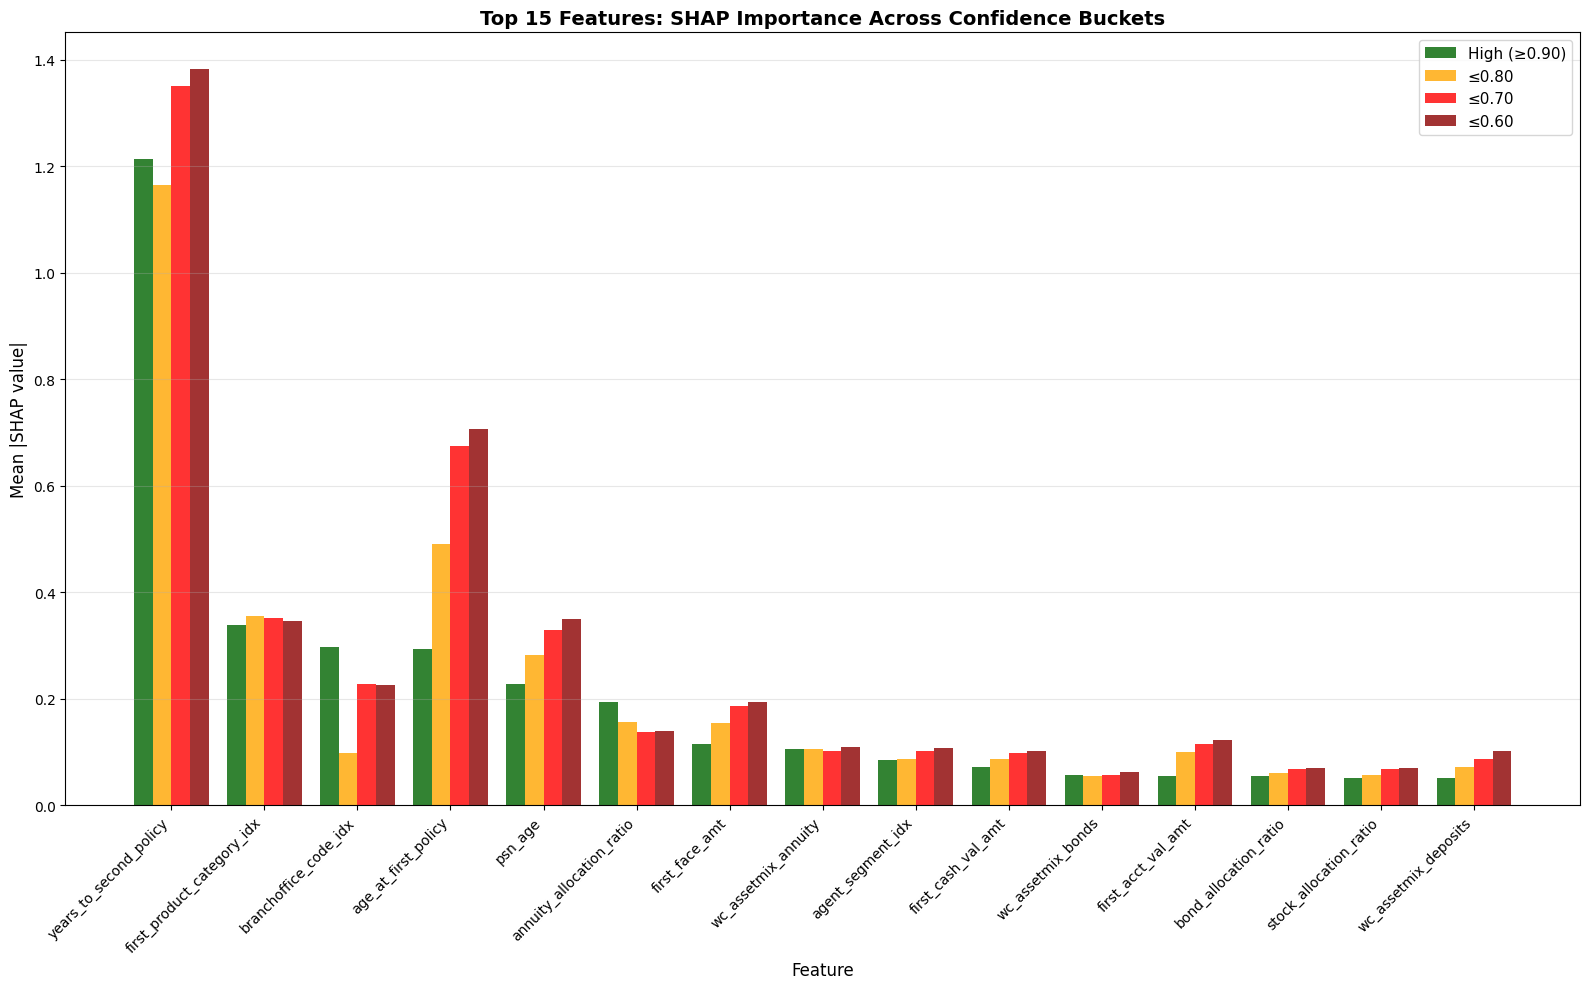

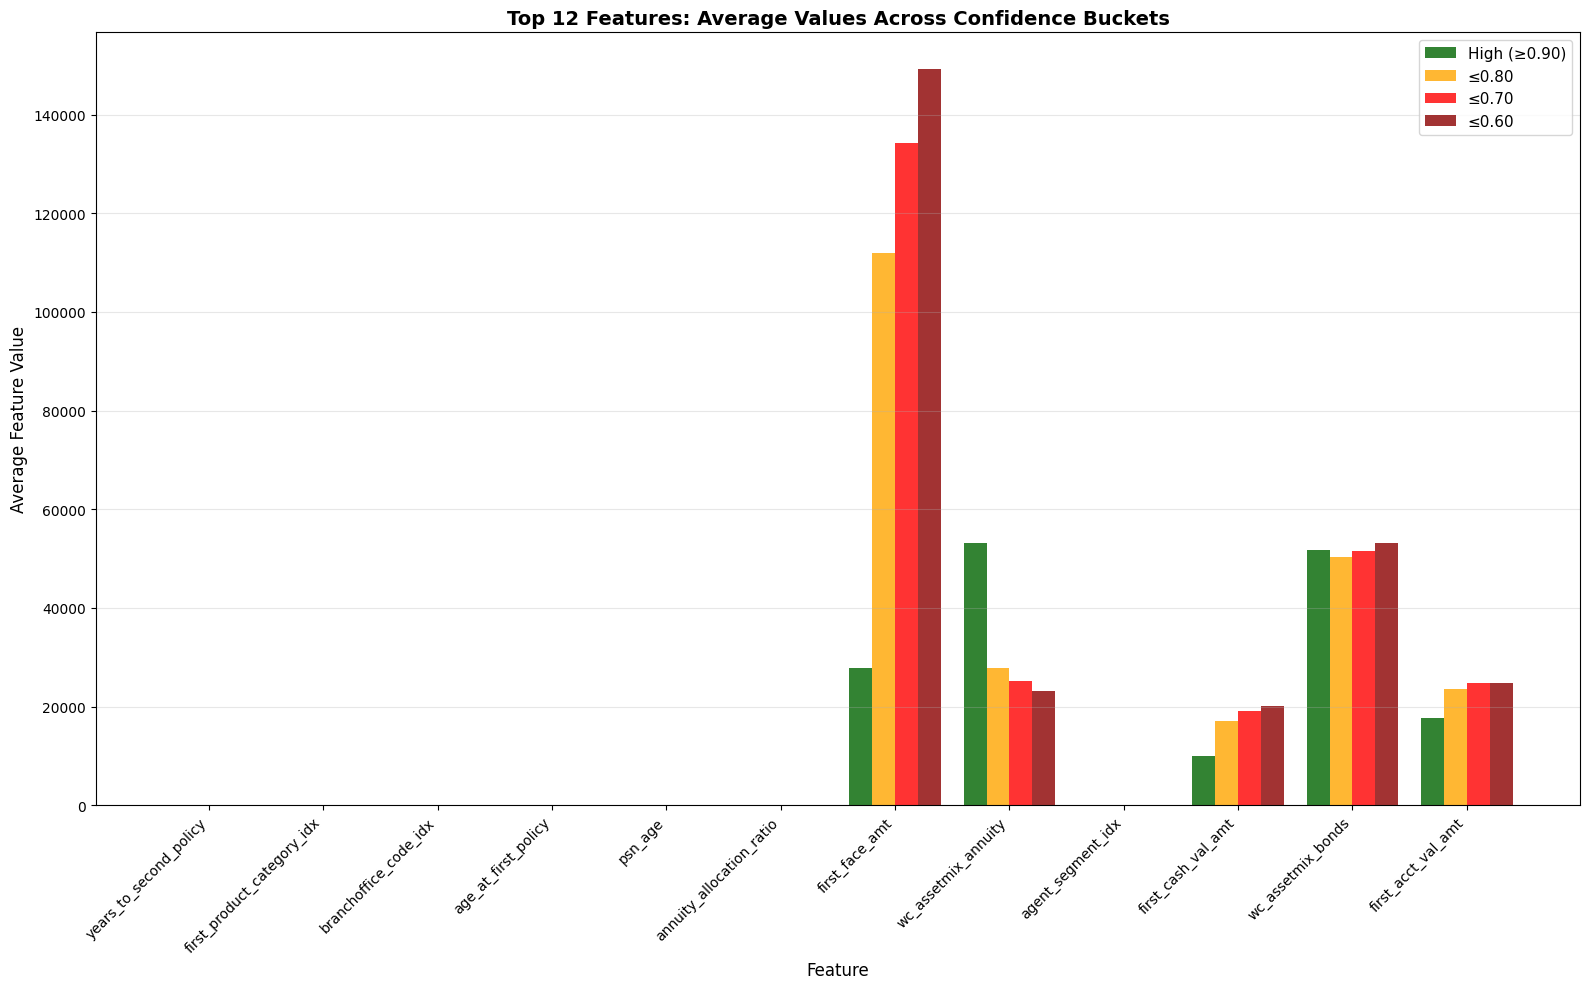

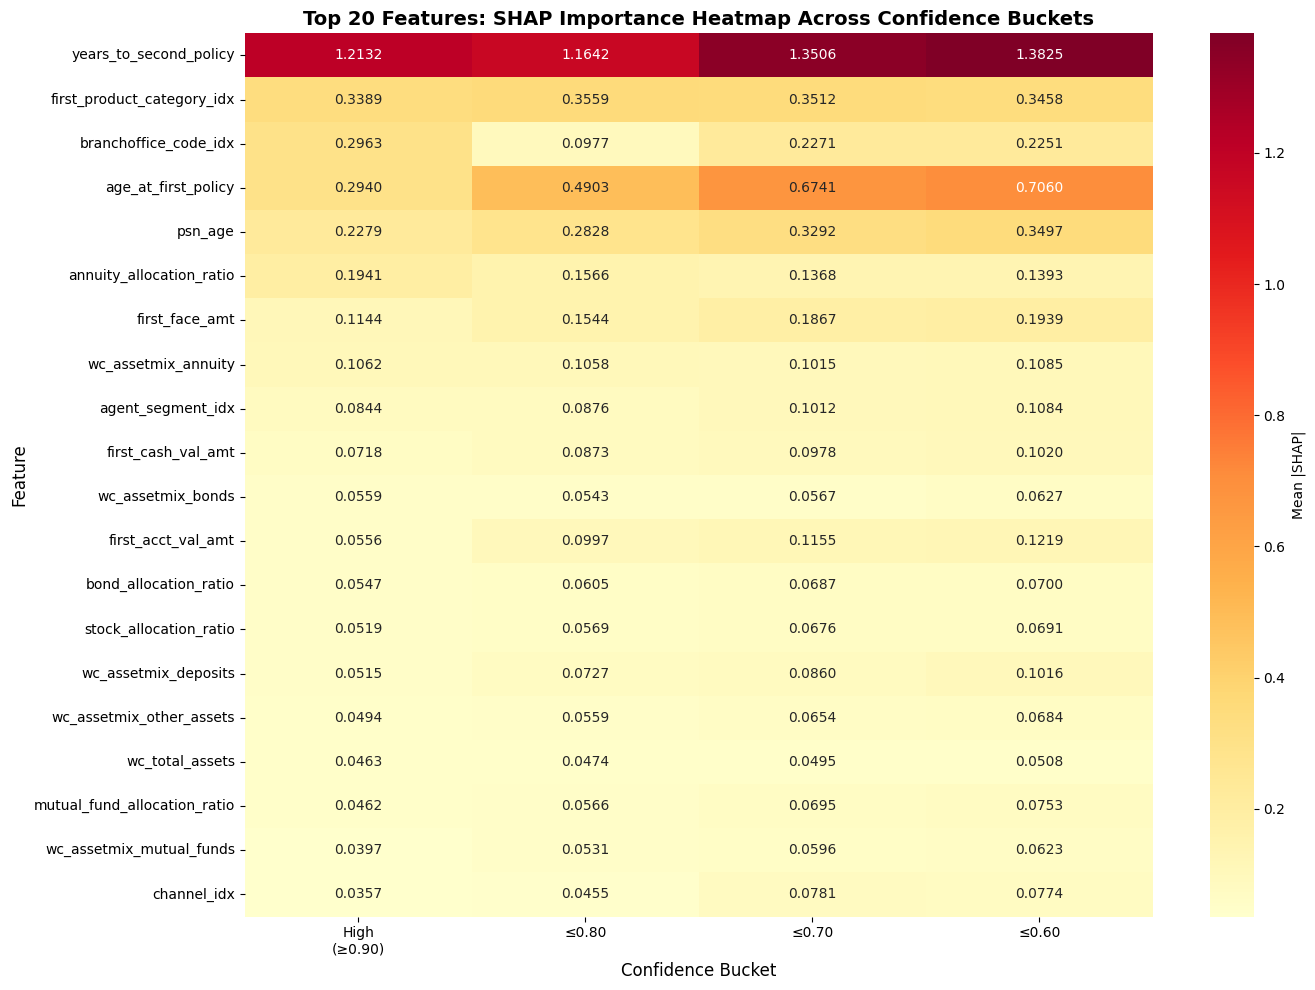

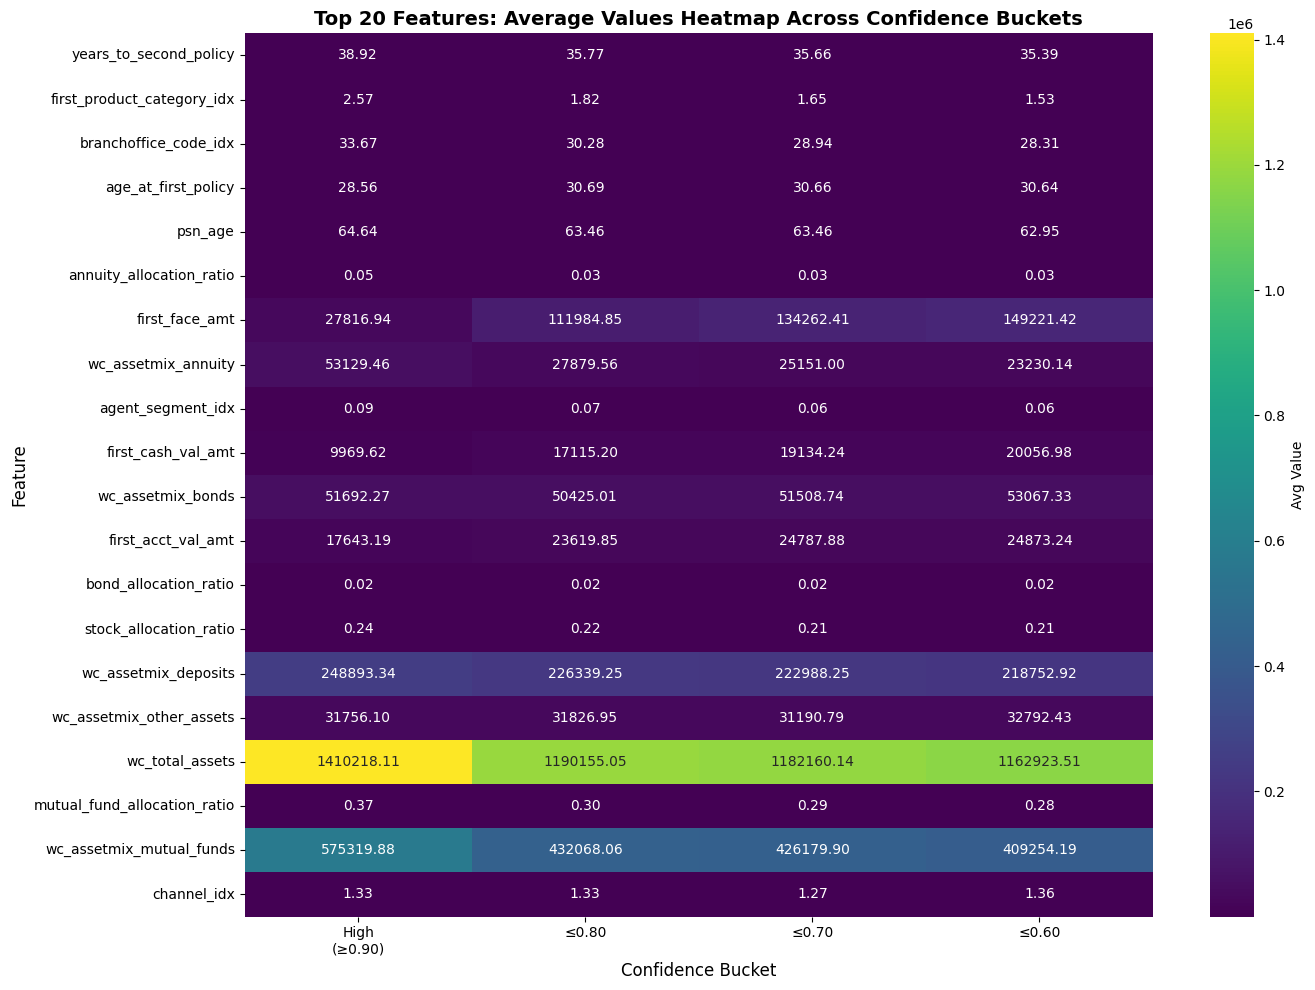

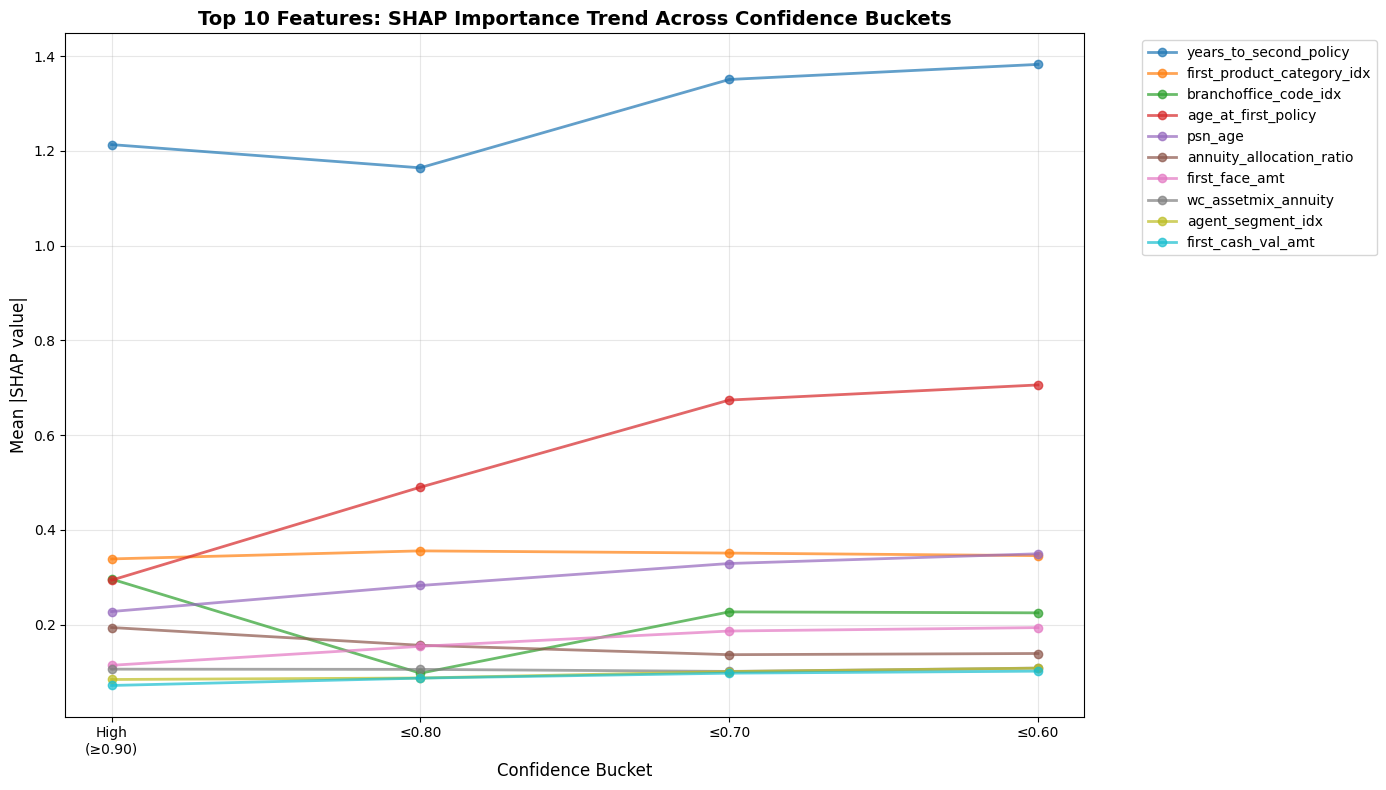

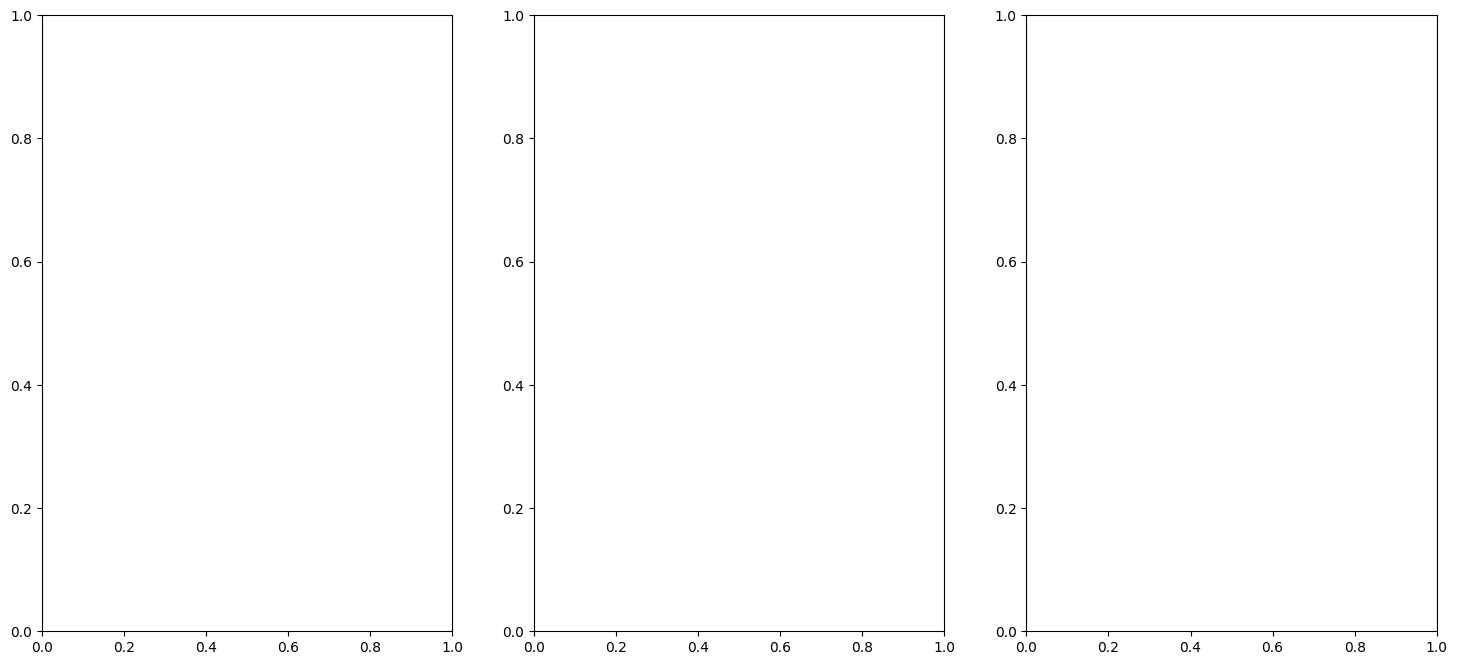

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-1349140375030255>, line 493
    490 top_diff = 15
    492 # High vs Med-Low
--> 493 top_diff_medlow = comparison_df.nlargest(top_diff, key=lambda x: abs(x["shap_diff_high_vs_medlow"]))
    494 colors_medlow = ["green" if d > 0 else "red" for d in top_diff_medlow["shap_diff_high_vs_medlow"]]
    495 axes[0].barh(range(len(top_diff_medlow)), top_diff_medlow["shap_diff_high_vs_medlow"], color=colors_medlow, alpha=0.7)

TypeError: DataFrame.nlargest() got an unexpected keyword argument 'key'

In [0]:
# ============================================================================
# GLOBAL SHAP COMPARISON: MULTIPLE CONFIDENCE BUCKETS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "=" * 80)
print("GLOBAL SHAP COMPARISON: MULTIPLE CONFIDENCE BUCKETS")
print("=" * 80)

# Load predictions from table
print("\nLoading predictions from table...")
df_predictions_full = spark.table(PREDICTIONS_TABLE)
print(f"✓ Loaded {df_predictions_full.count():,} total predictions")

# Divide into FOUR buckets based on pred_prob
print("\nDividing clients into confidence buckets...")
df_high_conf = df_predictions_full.filter(F.col("pred_prob") >= 0.90)
df_med_low_conf = df_predictions_full.filter(F.col("pred_prob") <= 0.80)
df_low_conf = df_predictions_full.filter(F.col("pred_prob") <= 0.70)
df_very_low_conf = df_predictions_full.filter(F.col("pred_prob") <= 0.60)

high_conf_count = df_high_conf.count()
med_low_conf_count = df_med_low_conf.count()
low_conf_count = df_low_conf.count()
very_low_conf_count = df_very_low_conf.count()

print(f"✓ High confidence (pred_prob >= 0.90): {high_conf_count:,} clients")
print(f"✓ Medium-low confidence (pred_prob <= 0.80): {med_low_conf_count:,} clients")
print(f"✓ Low confidence (pred_prob <= 0.70): {low_conf_count:,} clients")
print(f"✓ Very low confidence (pred_prob <= 0.60): {very_low_conf_count:,} clients")

# Sample if too large (for computational efficiency)
MAX_SAMPLES_PER_BUCKET = 40000

def sample_bucket(df, count, bucket_name):
    if count > MAX_SAMPLES_PER_BUCKET:
        print(f"⚠ Sampling {MAX_SAMPLES_PER_BUCKET:,} from {bucket_name} bucket...")
        df = df.sample(fraction=MAX_SAMPLES_PER_BUCKET / count, seed=42)
        count = df.count()
    return df, count

df_high_conf, high_conf_count = sample_bucket(df_high_conf, high_conf_count, "high confidence")
df_med_low_conf, med_low_conf_count = sample_bucket(df_med_low_conf, med_low_conf_count, "medium-low confidence")
df_low_conf, low_conf_count = sample_bucket(df_low_conf, low_conf_count, "low confidence")
df_very_low_conf, very_low_conf_count = sample_bucket(df_very_low_conf, very_low_conf_count, "very low confidence")

# Convert to pandas
pred_high_pd = df_high_conf.toPandas()
pred_med_low_pd = df_med_low_conf.toPandas()
pred_low_pd = df_low_conf.toPandas()
pred_very_low_pd = df_very_low_conf.toPandas()

print(f"\n✓ Working with:")
print(f"  - {len(pred_high_pd):,} high confidence predictions")
print(f"  - {len(pred_med_low_pd):,} medium-low confidence predictions")
print(f"  - {len(pred_low_pd):,} low confidence predictions")
print(f"  - {len(pred_very_low_pd):,} very low confidence predictions")

# ============================================================================
# RECONSTRUCT FEATURES FOR ALL BUCKETS
# ============================================================================

def reconstruct_features_for_bucket(pred_pd_bucket, bucket_name):
    """Reconstruct features for a bucket of predictions."""
    print(f"\n{'='*80}")
    print(f"RECONSTRUCTING FEATURES FOR {bucket_name.upper()} BUCKET")
    print(f"{'='*80}")
    
    # Get cont_ids
    cont_ids = pred_pd_bucket["cont_id"].unique().tolist()
    print(f"✓ Found {len(cont_ids):,} unique cont_ids")
    
    # Load source data
    df_raw = spark.table(SOURCE_TABLE)
    df_raw = df_raw.filter(F.col("cont_id").isin(cont_ids))
    df_raw = df_raw.filter(F.col("policy_status") == "Active")
    
    # Create product_category
    df_raw = create_product_category_column(df_raw)
    
    # Filter to single-policy clients
    df_events = df_raw.select(
        "cont_id",
        "axa_party_id",
        "product_category",
        "register_date",
        "isrd_brth_date",
        "acct_val_amt",
        "face_amt",
        "cash_val_amt",
        "wc_total_assets",
        "wc_assetmix_stocks",
        "wc_assetmix_bonds",
        "wc_assetmix_mutual_funds",
        "wc_assetmix_annuity",
        "wc_assetmix_deposits",
        "wc_assetmix_other_assets",
        "psn_age",
        "client_seg",
        "client_seg_1",
        "aum_band",
        "channel",
        "agent_segment",
        "branchoffice_code",
        "policy_no",
    ).filter(
        (F.col("axa_party_id").isNotNull())
        & (F.col("cont_id").isNotNull())
        & (F.col("register_date").isNotNull())
        & (F.col("product_category").isNotNull())
    )
    
    # Count policies per axa_party_id
    party_counts = (
        df_events.groupBy("axa_party_id")
        .agg(F.countDistinct("policy_no").alias("policy_count"))
        .filter(F.col("policy_count") == 1)
    )
    
    # Filter to single-policy clients
    df_single_policy = df_events.join(
        party_counts.select("axa_party_id"), on="axa_party_id", how="inner"
    ).dropDuplicates(["cont_id"])
    
    print(f"✓ Filtered to {df_single_policy.count():,} single-policy client records")
    
    # Convert dates
    df_single_policy = df_single_policy.withColumn("register_ts", F.to_timestamp("register_date"))
    df_single_policy = df_single_policy.withColumn("birth_ts", F.to_timestamp("isrd_brth_date"))
    
    # Create "first policy" features
    df_first = df_single_policy.select(
        "cont_id",
        "axa_party_id",
        F.col("product_category").alias("first_product_category"),
        F.col("register_ts").alias("first_register_ts"),
        "birth_ts",
        F.col("acct_val_amt").alias("first_acct_val_amt"),
        F.col("face_amt").alias("first_face_amt"),
        F.col("cash_val_amt").alias("first_cash_val_amt"),
        "wc_total_assets",
        "wc_assetmix_stocks",
        "wc_assetmix_bonds",
        "wc_assetmix_mutual_funds",
        "wc_assetmix_annuity",
        "wc_assetmix_deposits",
        "wc_assetmix_other_assets",
        "psn_age",
        "client_seg",
        "client_seg_1",
        "aum_band",
        "channel",
        "agent_segment",
        "branchoffice_code",
    )
    
    # Add temporal features
    df_first = df_first.withColumn("second_register_ts", F.current_timestamp())
    df_first = add_asset_allocation_ratios(df_first)
    
    df_first = df_first.withColumn(
        "season_of_first_policy",
        F.when(F.month("first_register_ts").between(1, 3), "Q1")
        .when(F.month("first_register_ts").between(4, 6), "Q2")
        .when(F.month("first_register_ts").between(7, 9), "Q3")
        .when(F.month("first_register_ts").between(10, 12), "Q4")
        .otherwise("Unknown"),
    )
    
    df_first = df_first.withColumn(
        "age_at_first_policy",
        F.datediff(F.col("first_register_ts"), F.col("birth_ts")) / 365.25,
    )
    
    df_first = df_first.withColumn(
        "years_to_second_policy",
        F.datediff(F.col("second_register_ts"), F.col("first_register_ts")) / 365.25,
    )
    
    # Impute missing values
    categorical_cols = [
        "first_product_category",
        "client_seg",
        "client_seg_1",
        "aum_band",
        "channel",
        "agent_segment",
        "branchoffice_code",
        "season_of_first_policy",
    ]
    
    df_first = impute_missing_values(df_first, categorical_cols)
    
    # Encode categorical features
    df_encoded, _ = encode_categorical_features(
        df_first, categorical_cols, spark.sparkContext, categorical_mappings=categorical_mappings
    )
    
    # Convert to pandas
    select_cols = ["cont_id", "axa_party_id"] + feature_cols
    available_cols = [col for col in select_cols if col in df_encoded.columns]
    features_pd = df_encoded.select(available_cols).toPandas()
    features_pd.fillna(0, inplace=True)
    
    print(f"✓ Reconstructed features for {len(features_pd):,} clients")
    
    return features_pd

# Reconstruct features for all buckets
features_high_pd = reconstruct_features_for_bucket(pred_high_pd, "HIGH CONFIDENCE (>=0.90)")
features_med_low_pd = reconstruct_features_for_bucket(pred_med_low_pd, "MEDIUM-LOW CONFIDENCE (<=0.80)")
features_low_pd = reconstruct_features_for_bucket(pred_low_pd, "LOW CONFIDENCE (<=0.70)")
features_very_low_pd = reconstruct_features_for_bucket(pred_very_low_pd, "VERY LOW CONFIDENCE (<=0.60)")

# Merge predictions with features
pred_high_with_features = pred_high_pd.merge(
    features_high_pd[["cont_id"] + feature_cols], on="cont_id", how="inner"
)
pred_med_low_with_features = pred_med_low_pd.merge(
    features_med_low_pd[["cont_id"] + feature_cols], on="cont_id", how="inner"
)
pred_low_with_features = pred_low_pd.merge(
    features_low_pd[["cont_id"] + feature_cols], on="cont_id", how="inner"
)
pred_very_low_with_features = pred_very_low_pd.merge(
    features_very_low_pd[["cont_id"] + feature_cols], on="cont_id", how="inner"
)

# Handle column name conflicts from merge (psn_age exists in both predictions and features)
for df in [pred_high_with_features, pred_med_low_with_features, pred_low_with_features, pred_very_low_with_features]:
    if 'psn_age_y' in df.columns:
        df['psn_age'] = df['psn_age_y']

print(f"\n✓ Merged predictions with features:")
print(f"  - High confidence: {len(pred_high_with_features):,} records")
print(f"  - Medium-low confidence: {len(pred_med_low_with_features):,} records")
print(f"  - Low confidence: {len(pred_low_with_features):,} records")
print(f"  - Very low confidence: {len(pred_very_low_with_features):,} records")

# ============================================================================
# COMPUTE SHAP VALUES FOR ALL BUCKETS
# ============================================================================

print("\n" + "=" * 80)
print("COMPUTING SHAP VALUES FOR ALL BUCKETS")
print("=" * 80)

def compute_shap_for_bucket(pred_with_features_bucket, bucket_name):
    """Compute SHAP values for a bucket."""
    print(f"\nComputing SHAP values for {bucket_name}...")
    
    # Verify all feature columns are present
    missing_cols = [col for col in feature_cols if col not in pred_with_features_bucket.columns]
    if missing_cols:
        print(f"⚠ Missing columns: {missing_cols}")
        available_cols = [col for col in feature_cols if col in pred_with_features_bucket.columns]
    else:
        available_cols = feature_cols
    
    # Prepare feature matrix
    X = pred_with_features_bucket[available_cols].values
    print(f"  Feature matrix shape: {X.shape}")
    
    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Get predictions to determine which class SHAP values to use
    pred_probs = model.predict(X)
    pred_class_ids = np.argmax(pred_probs, axis=1)
    
    # Handle SHAP output format
    if isinstance(shap_values, list):
        shap_array = np.array([shap_values[pred_class_ids[i]][i] for i in range(len(pred_with_features_bucket))])
    elif isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
        n_samples, n_features, n_classes = shap_values.shape
        if n_samples == len(pred_with_features_bucket) and n_features == len(available_cols):
            shap_array = np.array([shap_values[i, :, pred_class_ids[i]] for i in range(n_samples)])
        else:
            shap_values = shap_values.transpose(1, 0, 2)
            shap_array = np.array([shap_values[i, :, pred_class_ids[i]] for i in range(len(pred_with_features_bucket))])
    else:
        shap_array = shap_values
    
    print(f"  ✓ Computed SHAP values: {shap_array.shape}")
    
    return shap_array, available_cols

# Compute SHAP for all buckets
shap_high, feature_cols_high = compute_shap_for_bucket(pred_high_with_features, "HIGH CONFIDENCE")
shap_med_low, feature_cols_med_low = compute_shap_for_bucket(pred_med_low_with_features, "MEDIUM-LOW CONFIDENCE")
shap_low, feature_cols_low = compute_shap_for_bucket(pred_low_with_features, "LOW CONFIDENCE")
shap_very_low, feature_cols_very_low = compute_shap_for_bucket(pred_very_low_with_features, "VERY LOW CONFIDENCE")

# Ensure all use the same feature columns
common_features = [f for f in feature_cols 
                   if f in feature_cols_high 
                   and f in feature_cols_med_low 
                   and f in feature_cols_low 
                   and f in feature_cols_very_low]
print(f"\n✓ Common features for comparison: {len(common_features)}/{len(feature_cols)}")

# Filter SHAP arrays to common features
def filter_shap_to_common(shap_array, feature_list, common_features):
    feature_idx_map = {f: i for i, f in enumerate(feature_list) if f in common_features}
    return np.array([[shap_array[i, feature_idx_map[f]] for f in common_features] 
                     for i in range(len(shap_array))])

shap_high_common = filter_shap_to_common(shap_high, feature_cols_high, common_features)
shap_med_low_common = filter_shap_to_common(shap_med_low, feature_cols_med_low, common_features)
shap_low_common = filter_shap_to_common(shap_low, feature_cols_low, common_features)
shap_very_low_common = filter_shap_to_common(shap_very_low, feature_cols_very_low, common_features)

# ============================================================================
# COMPARE FEATURE IMPORTANCE AND VALUES ACROSS ALL BUCKETS
# ============================================================================

print("\n" + "=" * 80)
print("COMPARING FEATURE IMPORTANCE AND VALUES ACROSS ALL BUCKETS")
print("=" * 80)

# Compute mean absolute SHAP per feature for each bucket
mean_abs_shap_high = np.mean(np.abs(shap_high_common), axis=0)
mean_abs_shap_med_low = np.mean(np.abs(shap_med_low_common), axis=0)
mean_abs_shap_low = np.mean(np.abs(shap_low_common), axis=0)
mean_abs_shap_very_low = np.mean(np.abs(shap_very_low_common), axis=0)

# Compute average feature values for each bucket
mean_feature_high = pred_high_with_features[common_features].mean()
mean_feature_med_low = pred_med_low_with_features[common_features].mean()
mean_feature_low = pred_low_with_features[common_features].mean()
mean_feature_very_low = pred_very_low_with_features[common_features].mean()

# Create comprehensive comparison DataFrame
comparison_df = pd.DataFrame({
    "feature": common_features,
    "high_conf_shap": mean_abs_shap_high,
    "med_low_conf_shap": mean_abs_shap_med_low,
    "low_conf_shap": mean_abs_shap_low,
    "very_low_conf_shap": mean_abs_shap_very_low,
    "high_conf_value": mean_feature_high.values,
    "med_low_conf_value": mean_feature_med_low.values,
    "low_conf_value": mean_feature_low.values,
    "very_low_conf_value": mean_feature_very_low.values,
})

# Compute differences from high confidence bucket
comparison_df["shap_diff_high_vs_medlow"] = comparison_df["high_conf_shap"] - comparison_df["med_low_conf_shap"]
comparison_df["shap_diff_high_vs_low"] = comparison_df["high_conf_shap"] - comparison_df["low_conf_shap"]
comparison_df["shap_diff_high_vs_verylow"] = comparison_df["high_conf_shap"] - comparison_df["very_low_conf_shap"]

comparison_df["value_diff_high_vs_medlow"] = comparison_df["high_conf_value"] - comparison_df["med_low_conf_value"]
comparison_df["value_diff_high_vs_low"] = comparison_df["high_conf_value"] - comparison_df["low_conf_value"]
comparison_df["value_diff_high_vs_verylow"] = comparison_df["high_conf_value"] - comparison_df["very_low_conf_value"]

# Sort by SHAP importance in high confidence bucket
comparison_df = comparison_df.sort_values("high_conf_shap", ascending=False)

print(f"\n✓ Feature importance and value comparison:")
print(f"  Total features compared: {len(comparison_df)}")
print(f"\n  Top 15 features by SHAP importance in high confidence bucket:")
display(comparison_df[["feature", "high_conf_shap", "med_low_conf_shap", "low_conf_shap", "very_low_conf_shap",
                       "high_conf_value", "med_low_conf_value", "low_conf_value", "very_low_conf_value"]].head(15))

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "=" * 80)
print("CREATING COMPARISON VISUALIZATIONS")
print("=" * 80)

# 1. Multi-bucket bar plot of top features (SHAP importance)
plt.figure(figsize=(16, 10))
top_n = 15
top_features = comparison_df.head(top_n)["feature"].tolist()

x = np.arange(len(top_features))
width = 0.2

high_values = [comparison_df[comparison_df["feature"] == f]["high_conf_shap"].values[0] for f in top_features]
med_low_values = [comparison_df[comparison_df["feature"] == f]["med_low_conf_shap"].values[0] for f in top_features]
low_values = [comparison_df[comparison_df["feature"] == f]["low_conf_shap"].values[0] for f in top_features]
very_low_values = [comparison_df[comparison_df["feature"] == f]["very_low_conf_shap"].values[0] for f in top_features]

plt.bar(x - 1.5*width, high_values, width, label="High (≥0.90)", color="darkgreen", alpha=0.8)
plt.bar(x - 0.5*width, med_low_values, width, label="≤0.80", color="orange", alpha=0.8)
plt.bar(x + 0.5*width, low_values, width, label="≤0.70", color="red", alpha=0.8)
plt.bar(x + 1.5*width, very_low_values, width, label="≤0.60", color="darkred", alpha=0.8)

plt.xlabel("Feature", fontsize=12)
plt.ylabel("Mean |SHAP value|", fontsize=12)
plt.title(f"Top {top_n} Features: SHAP Importance Across Confidence Buckets", fontsize=14, fontweight="bold")
plt.xticks(x, top_features, rotation=45, ha="right")
plt.legend(fontsize=11)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Feature value comparison for top features
plt.figure(figsize=(16, 10))
top_n_values = 12
top_features_values = comparison_df.head(top_n_values)["feature"].tolist()

x = np.arange(len(top_features_values))
width = 0.2

high_feat_values = [comparison_df[comparison_df["feature"] == f]["high_conf_value"].values[0] for f in top_features_values]
med_low_feat_values = [comparison_df[comparison_df["feature"] == f]["med_low_conf_value"].values[0] for f in top_features_values]
low_feat_values = [comparison_df[comparison_df["feature"] == f]["low_conf_value"].values[0] for f in top_features_values]
very_low_feat_values = [comparison_df[comparison_df["feature"] == f]["very_low_conf_value"].values[0] for f in top_features_values]

plt.bar(x - 1.5*width, high_feat_values, width, label="High (≥0.90)", color="darkgreen", alpha=0.8)
plt.bar(x - 0.5*width, med_low_feat_values, width, label="≤0.80", color="orange", alpha=0.8)
plt.bar(x + 0.5*width, low_feat_values, width, label="≤0.70", color="red", alpha=0.8)
plt.bar(x + 1.5*width, very_low_feat_values, width, label="≤0.60", color="darkred", alpha=0.8)

plt.xlabel("Feature", fontsize=12)
plt.ylabel("Average Feature Value", fontsize=12)
plt.title(f"Top {top_n_values} Features: Average Values Across Confidence Buckets", fontsize=14, fontweight="bold")
plt.xticks(x, top_features_values, rotation=45, ha="right")
plt.legend(fontsize=11)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Heatmap: SHAP importance across buckets
plt.figure(figsize=(14, 10))
top_n_heatmap = 20
top_features_heatmap = comparison_df.head(top_n_heatmap)["feature"].tolist()

shap_matrix = comparison_df[comparison_df["feature"].isin(top_features_heatmap)][
    ["high_conf_shap", "med_low_conf_shap", "low_conf_shap", "very_low_conf_shap"]
].values

sns.heatmap(shap_matrix, 
            xticklabels=["High\n(≥0.90)", "≤0.80", "≤0.70", "≤0.60"],
            yticklabels=top_features_heatmap,
            annot=True, fmt=".4f", cmap="YlOrRd", cbar_kws={'label': 'Mean |SHAP|'})
plt.title(f"Top {top_n_heatmap} Features: SHAP Importance Heatmap Across Confidence Buckets", 
          fontsize=14, fontweight="bold")
plt.xlabel("Confidence Bucket", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# 4. Heatmap: Average feature values across buckets
plt.figure(figsize=(14, 10))
value_matrix = comparison_df[comparison_df["feature"].isin(top_features_heatmap)][
    ["high_conf_value", "med_low_conf_value", "low_conf_value", "very_low_conf_value"]
].values

sns.heatmap(value_matrix, 
            xticklabels=["High\n(≥0.90)", "≤0.80", "≤0.70", "≤0.60"],
            yticklabels=top_features_heatmap,
            annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Avg Value'})
plt.title(f"Top {top_n_heatmap} Features: Average Values Heatmap Across Confidence Buckets", 
          fontsize=14, fontweight="bold")
plt.xlabel("Confidence Bucket", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# # 4b. Decode categorical features (_idx columns) and display mode values
# print("\n" + "=" * 80)
# print("CATEGORICAL FEATURE MODE VALUES (DECODED)")
# print("=" * 80)

# # Create reverse mappings for categorical features
# reverse_categorical_mappings = {}
# for cat_col, mapping in categorical_mappings.items():
#     reverse_categorical_mappings[cat_col + "_idx"] = {v: k for k, v in mapping.items()}

# # Identify _idx columns in top features
# idx_features = [f for f in top_features_heatmap if f.endswith("_idx")]

# if idx_features:
#     print(f"\nFound {len(idx_features)} categorical features in top {top_n_heatmap}:")
    
#     # Create a DataFrame to store mode values
#     mode_data = []
    
#     for idx_feature in idx_features:
#         # Get mode (most common value) for each bucket
#         mode_high = pred_high_with_features[idx_feature].mode()[0] if len(pred_high_with_features[idx_feature].mode()) > 0 else 0
#         mode_med_low = pred_med_low_with_features[idx_feature].mode()[0] if len(pred_med_low_with_features[idx_feature].mode()) > 0 else 0
#         mode_low = pred_low_with_features[idx_feature].mode()[0] if len(pred_low_with_features[idx_feature].mode()) > 0 else 0
#         mode_very_low = pred_very_low_with_features[idx_feature].mode()[0] if len(pred_very_low_with_features[idx_feature].mode()) > 0 else 0
        
#         # Decode the mode values
#         reverse_map = reverse_categorical_mappings.get(idx_feature, {})
        
#         decoded_high = reverse_map.get(int(mode_high), f"Unknown({int(mode_high)})")
#         decoded_med_low = reverse_map.get(int(mode_med_low), f"Unknown({int(mode_med_low)})")
#         decoded_low = reverse_map.get(int(mode_low), f"Unknown({int(mode_low)})")
#         decoded_very_low = reverse_map.get(int(mode_very_low), f"Unknown({int(mode_very_low)})")
        
#         mode_data.append({
#             "Feature": idx_feature,
#             "High (≥0.90)": decoded_high,
#             "≤0.80": decoded_med_low,
#             "≤0.70": decoded_low,
#             "≤0.60": decoded_very_low
#         })
    
#     mode_df = pd.DataFrame(mode_data)
#     print(f"\nMode (Most Common) Values for Categorical Features:")
#     display(mode_df)
    
#     # Also create a visual representation
#     fig, ax = plt.subplots(figsize=(16, max(6, len(idx_features) * 0.8)))
#     ax.axis('tight')
#     ax.axis('off')
    
#     table = ax.table(cellText=mode_df.values, 
#                      colLabels=mode_df.columns,
#                      cellLoc='left',
#                      loc='center',
#                      colWidths=[0.25, 0.2, 0.15, 0.15, 0.15])
    
#     table.auto_set_font_size(False)
#     table.set_fontsize(9)
#     table.scale(1, 2)
    
#     # Style header
#     for i in range(len(mode_df.columns)):
#         table[(0, i)].set_facecolor('#40466e')
#         table[(0, i)].set_text_props(weight='bold', color='white')
    
#     # Alternate row colors
#     for i in range(1, len(mode_df) + 1):
#         for j in range(len(mode_df.columns)):
#             if i % 2 == 0:
#                 table[(i, j)].set_facecolor('#f0f0f0')
    
#     plt.title(f"Categorical Features: Mode Values Across Confidence Buckets", 
#               fontsize=14, fontweight="bold", pad=20)
#     plt.tight_layout()
#     plt.show()
# else:
#     print("\nNo categorical (_idx) features found in top features.")

# 5. Line plot: SHAP importance trend across buckets
plt.figure(figsize=(14, 8))
top_n_line = 10
top_features_line = comparison_df.head(top_n_line)["feature"].tolist()

buckets = ["High\n(≥0.90)", "≤0.80", "≤0.70", "≤0.60"]

for feature in top_features_line:
    feature_row = comparison_df[comparison_df["feature"] == feature].iloc[0]
    values = [feature_row["high_conf_shap"], feature_row["med_low_conf_shap"], 
              feature_row["low_conf_shap"], feature_row["very_low_conf_shap"]]
    plt.plot(buckets, values, marker='o', linewidth=2, label=feature, alpha=0.7)

plt.xlabel("Confidence Bucket", fontsize=12)
plt.ylabel("Mean |SHAP value|", fontsize=12)
plt.title(f"Top {top_n_line} Features: SHAP Importance Trend Across Confidence Buckets", 
          fontsize=14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Difference plot: High vs other buckets
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
top_diff = 15

# High vs Med-Low
comparison_df["abs_shap_diff_high_vs_medlow"] = comparison_df["shap_diff_high_vs_medlow"].abs()
top_diff_medlow = comparison_df.nlargest(top_diff, "abs_shap_diff_high_vs_medlow")
colors_medlow = ["green" if d > 0 else "red" for d in top_diff_medlow["shap_diff_high_vs_medlow"]]
axes[0].barh(range(len(top_diff_medlow)), top_diff_medlow["shap_diff_high_vs_medlow"], color=colors_medlow, alpha=0.7)
axes[0].set_yticks(range(len(top_diff_medlow)))
axes[0].set_yticklabels(top_diff_medlow["feature"], fontsize=9)
axes[0].set_xlabel("SHAP Difference", fontsize=11)
axes[0].set_title("High vs ≤0.80", fontsize=12, fontweight="bold")
axes[0].axvline(x=0, color="black", linestyle="--", linewidth=1)
axes[0].grid(axis="x", alpha=0.3)

# High vs Low
comparison_df["abs_shap_diff_high_vs_low"] = comparison_df["shap_diff_high_vs_low"].abs()
top_diff_low = comparison_df.nlargest(top_diff, "abs_shap_diff_high_vs_low")
colors_low = ["green" if d > 0 else "red" for d in top_diff_low["shap_diff_high_vs_low"]]
axes[1].barh(range(len(top_diff_low)), top_diff_low["shap_diff_high_vs_low"], color=colors_low, alpha=0.7)
axes[1].set_yticks(range(len(top_diff_low)))
axes[1].set_yticklabels(top_diff_low["feature"], fontsize=9)
axes[1].set_xlabel("SHAP Difference", fontsize=11)
axes[1].set_title("High vs ≤0.70", fontsize=12, fontweight="bold")
axes[1].axvline(x=0, color="black", linestyle="--", linewidth=1)
axes[1].grid(axis="x", alpha=0.3)

# High vs Very Low
comparison_df["abs_shap_diff_high_vs_verylow"] = comparison_df["shap_diff_high_vs_verylow"].abs()
top_diff_verylow = comparison_df.nlargest(top_diff, "abs_shap_diff_high_vs_verylow")
colors_verylow = ["green" if d > 0 else "red" for d in top_diff_verylow["shap_diff_high_vs_verylow"]]
axes[2].barh(range(len(top_diff_verylow)), top_diff_verylow["shap_diff_high_vs_verylow"], color=colors_verylow, alpha=0.7)
axes[2].set_yticks(range(len(top_diff_verylow)))
axes[2].set_yticklabels(top_diff_verylow["feature"], fontsize=9)
axes[2].set_xlabel("SHAP Difference", fontsize=11)
axes[2].set_title("High vs ≤0.60", fontsize=12, fontweight="bold")
axes[2].axvline(x=0, color="black", linestyle="--", linewidth=1)
axes[2].grid(axis="x", alpha=0.3)

plt.suptitle(f"Top {top_diff} Features: SHAP Importance Differences (High Confidence vs Others)", 
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS AND INSIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("SUMMARY STATISTICS BY CONFIDENCE BUCKET")
print("=" * 80)

print(f"\n1. Bucket Sizes:")
print(f"   - High confidence (≥0.90): {len(pred_high_with_features):,} predictions")
print(f"   - Medium-low confidence (≤0.80): {len(pred_med_low_with_features):,} predictions")
print(f"   - Low confidence (≤0.70): {len(pred_low_with_features):,} predictions")
print(f"   - Very low confidence (≤0.60): {len(pred_very_low_with_features):,} predictions")

print(f"\n2. Average SHAP Importance by Bucket:")
print(f"   - High confidence: {comparison_df['high_conf_shap'].mean():.4f}")
print(f"   - Medium-low confidence: {comparison_df['med_low_conf_shap'].mean():.4f}")
print(f"   - Low confidence: {comparison_df['low_conf_shap'].mean():.4f}")
print(f"   - Very low confidence: {comparison_df['very_low_conf_shap'].mean():.4f}")

print(f"\n3. Top 5 Features by SHAP Importance (High Confidence):")
for idx, row in comparison_df.head(5).iterrows():
    print(f"   - {row['feature']}:")
    print(f"     SHAP: High={row['high_conf_shap']:.4f}, ≤0.80={row['med_low_conf_shap']:.4f}, "
          f"≤0.70={row['low_conf_shap']:.4f}, ≤0.60={row['very_low_conf_shap']:.4f}")
    print(f"     Value: High={row['high_conf_value']:.2f}, ≤0.80={row['med_low_conf_value']:.2f}, "
          f"≤0.70={row['low_conf_value']:.2f}, ≤0.60={row['very_low_conf_value']:.2f}")

print(f"\n4. Features with Largest SHAP Difference (High vs ≤0.60):")
top_3_diff = comparison_df.nlargest(3, "abs_shap_diff_high_vs_verylow")
for _, row in top_3_diff.iterrows():
    direction = "higher" if row["shap_diff_high_vs_verylow"] > 0 else "lower"
    print(f"   - {row['feature']}: {abs(row['shap_diff_high_vs_verylow']):.4f} {direction} in high confidence")

print(f"\n5. Features with Largest Value Difference (High vs ≤0.60):")
comparison_df["abs_value_diff_high_vs_verylow"] = comparison_df["value_diff_high_vs_verylow"].abs()
top_3_value_diff = comparison_df.nlargest(3, "abs_value_diff_high_vs_verylow")
for _, row in top_3_value_diff.iterrows():
    direction = "higher" if row["value_diff_high_vs_verylow"] > 0 else "lower"
    print(f"   - {row['feature']}: {abs(row['value_diff_high_vs_verylow']):.2f} {direction} in high confidence")

# Predicted product distribution by bucket
pred_product_col = "predicted_product" if "predicted_product" in pred_high_with_features.columns else "pred_product"

if pred_product_col in pred_high_with_features.columns:
    print(f"\n6. Predicted Product Distribution by Bucket:")
    
    for bucket_name, bucket_df in [("High (≥0.90)", pred_high_with_features),
                                     ("≤0.80", pred_med_low_with_features),
                                     ("≤0.70", pred_low_with_features),
                                     ("≤0.60", pred_very_low_with_features)]:
        print(f"\n   {bucket_name}:")
        prod_counts = bucket_df[pred_product_col].value_counts()
        for product, count in prod_counts.head(5).items():
            print(f"     - {product}: {count:,} ({count/len(bucket_df)*100:.1f}%)")

print("\n" + "=" * 80)
print("GLOBAL SHAP COMPARISON COMPLETE")
print("=" * 80)